# Dependencies 

## Imports 

In [37]:
# imports 
# base python
import os
import copy
import re
from sys import getsizeof
import random

# scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import preprocessing
import matplotlib.tri as tri

plt.rcParams["figure.figsize"] = (20,7)

#ase
from ase.io import gen, vasp, xyz, extxyz, dftb
from ase.io.dftb import read_dftb_velocities, write_dftb_velocities
from ase.calculators.dftb import Dftb
from ase import Atoms, Atom
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
import nglview
from ase.geometry.analysis import Analysis

#dscribe
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR
from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

from sklearn import preprocessing


#quippy 
from ase.build import bulk
from ase.optimize import LBFGS
from ase.visualize import view
from quippy.potential import Potential


#misc
import similaritymeasures


## Functions

In [59]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def viewcelltop(data, save= False, filename = 'grid_configs'):
    '''
    Where data is an Atoms object
    Returns 
    '''
    fig, ax = plt.subplots()
    a, b, c = data.cell
    a_x, a_y, a_z = a
    b_x, b_y, b_z = b
    ax.plot([0, a_x], [0, a_y])
    ax.plot([0, b_x], [0, b_y])
    return fig, ax
        
def normalize(y,x):
    """
    Tagenkes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5

## Structures

In [3]:
mef = vasp.read_vasp("reference_files/CONTCAR_mef")
cf4 = vasp.read_vasp("reference_files/CONTCAR_cf4")
amorphous = vasp.read_vasp("reference_files/CONTCAR_amorphous_cubic")
xtl_n = vasp.read_vasp("reference_files/CONTCAR_nrich")
xtl_si = vasp.read_vasp("reference_files/CONTCAR_sirich")
xtl2x2 = gen.read_gen("reference_files/2x2xtl.gen")
xtl2x2_sifterm = gen.read_gen("reference_files/2x2xtl_sifterm.gen")
heavy_bomb = vasp.read_vasp("reference_files/CONTCAR_heavy_bombard")
bulk222 = vasp.read_vasp("reference_files/CONTCAR_222bulk")
annealed = vasp.read_vasp("reference_files/CONTCAR_annealed_unitcell")

# Generation

In [4]:
view(xtl2x2_sifterm)

In [93]:
generation = 0 # which bombardment stage, 0 representing starting at xtl 
numbatch = 10 # number of batch per generation
numsims = 17 # number of simulations per batch; 17 = 68/4 cores for running on stampede2
numstructs = 170 # total number of structures per generation
base = xtl2x2_sifterm # substrate to be bombarded
base = base.copy() # set base to be a copy, preserve original structure
outputdir = Path("../ftermbombinputs")

random.seed(429)
# following block goes through the random numbers already seen in the simulation
# IMPORTANT to make sure the generation number corresponds to current generation being studied
for g in range(generation):
    for f in range(numbatch):
        for run in range(numsims):
            print(f, run)
            x_rand, y_rand, z_rand = np.random.random(size = 3)
            
# set random Ar positions for numbatch*numsims geometries
newgeoms = []
for f in range(numbatch):
    for run in range(numsims):
        basecopy = base.copy() # fresh copy for each geometry
        x_rand, y_rand, z_rand = basecopy.cell.cartesian_positions(np.random.random(size = 3))
        add_adsorbate(basecopy, adsorbate = 'Ar', height = 7, position = (x_rand, y_rand))
        gen.write_gen(open((outputdir.joinpath("input%d-%d" % (f, run))), 'w'), basecopy)
        newgeoms += [basecopy]

view(newgeoms)

Visualize Argon positions

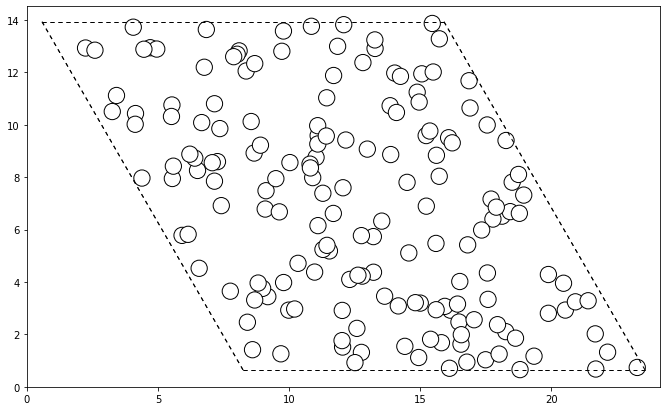

In [94]:
addedArgons = []
for geom in newgeoms:
    for atom in geom:
        if atom.symbol == 'Ar':
            addedArgons += [atom]
for i in addedArgons:
    i.symbol = 'H' # set it to be H, to be as close to small dots as we can 
test = (Atoms(addedArgons))
test.set_cell(xtl2x2_sifterm.cell)

plot_atoms(test);